# BBP data fi curve visualization

### Load modules

In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pickle
import pandas as pd

from ipywidgets import interactive, interact, Button, HBox, VBox
from IPython.display import display
import ipywidgets as widgets

import bluebrain_data_io as bbp_io

%matplotlib inline
plt.style.use('ggplot')
mpl.rcParams['font.size'] = 12
#mpl.rcParams['axes.facecolor'] = 'white'

result_path = './results/lif_fits/'

## Low level loading and plotting functions

In [2]:
def load_fi_data(cell_type):
    with open(result_path+'fi_curve_data_' + cell_type + '.pkl','rb') as f:
        loaded_data = pickle.load(f)
    return loaded_data

def plot_all_fi_curves(fi_curve_data):
    i_values = fi_curve_data['current_amplitudes']
    f_values = fi_curve_data['firing_rates']
    cell_names = fi_curve_data['cell_names']
    plt.figure()
    for cell in cell_names:
        if not len(i_values[cell]) == 0:
            plt.plot(i_values[cell], f_values[cell], '.-', ms=12, label=cell)
    plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1), ncol=1)
    plt.xlabel('Input current [pA]')
    plt.ylabel('Firing rate [Hz]')
    plt.title(fi_curve_data['cell_type'])
    plt.show()
    
def plot_single_cell_fi_curve(fi_curve_data, cell_name):
    i_values = fi_curve_data['current_amplitudes']
    f_values = fi_curve_data['firing_rates']
    cell_names = fi_curve_data['cell_names']
    plt.figure()
    if not len(i_values[cell_name]) == 0:
        plt.plot(i_values[cell_name], f_values[cell_name], '.-', ms=12, label=cell_name)
    plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1), ncol=1)
    plt.xlabel('Input current [pA]')
    plt.ylabel('Firing rate [Hz]')
    plt.title(fi_curve_data['cell_type'])
    plt.show()
    
def show_all_cell_names(fi_curve_data):
    for cell in fi_curve_data['cell_names']:
        print(cell)
        
def show_parameters(fi_curve_data):
    print(fi_curve_data['parameters'])
        
# Example usage
'''
loaded_data = load_fi_data('vip')
plot_all_fi_curves(loaded_data)
plot_single_cell_fi_curve(loaded_data, 'Cell_A87_single_traces')
show_all_cell_names(loaded_data)
show_parameters(loaded_data)
'''

"\nloaded_data = load_fi_data('vip')\nplot_all_fi_curves(loaded_data)\nplot_single_cell_fi_curve(loaded_data, 'Cell_A87_single_traces')\nshow_all_cell_names(loaded_data)\nshow_parameters(loaded_data)\n"

## Load data

In [3]:
vip_data = load_fi_data('vip')
som_data = load_fi_data('som')
pv_data = load_fi_data('pv')
datasets = [vip_data, som_data, pv_data]

## Plotting functions for the interactive plot

In [4]:
def get_binwise_mean(i_indeces, fi_matrix, binwidth, binoverlap, take_median):
    """
    Calculates mean/median in consecutive overlapping bins.
    """
    nbins = (len(i_indeces)-binwidth)//(binwidth-binoverlap)
    binmeans = np.zeros(nbins)
    binstds = np.zeros(nbins)
    bin_indeces = np.zeros(nbins)
    for i, binstart in enumerate(np.arange(0,len(i_indeces)-binwidth, step=(binwidth-binoverlap))):
        if take_median:
            binmeans[i] = np.nanmedian(fi_matrix[:,binstart:binstart+binwidth])
        else:
            binmeans[i] = np.nanmean(fi_matrix[:,binstart:binstart+binwidth])
        binstds[i] = np.sqrt(np.nanvar(fi_matrix[:,binstart:binstart+binwidth]))
        bin_indeces[i] = np.mean(i_indeces[binstart:binstart+binwidth])
    return binmeans, binstds, bin_indeces

def create_fi_matrix(fi_curve_data):
    """
    Takes an fi curve dataset and creates an according matrix where each columns is for one current amplitude.
    """
    i_values = fi_curve_data['current_amplitudes']
    f_values = fi_curve_data['firing_rates']
    cell_names = fi_curve_data['cell_names']
    cell_type = fi_curve_data['cell_type']

    all_f_values = []
    all_i_values = []
    all_cell_names = []
    total_nsamples = 0
    for i_vals, f_vals, cell_name in zip(i_values.values(), f_values.values(), cell_names):        
        if not len(i_vals) == 0:
            total_nsamples = total_nsamples + np.max(pd.value_counts(i_vals))

        all_i_values.extend(i_vals)
        all_f_values.extend(f_vals)
        all_cell_names.extend(np.tile(cell_name,len(i_vals)))
        
    i_indeces = sorted(pd.unique(all_i_values))
    fi_matrix = np.zeros(shape=(total_nsamples,len(i_indeces)))
    fi_matrix[:,:] = np.nan
    
    # remove 'blocked firing', i.e. firing rates that decrease again with increasing input current
    for cell_idx, cell in enumerate(cell_names):
        chosen_i = np.array(i_values[cell])
        chosen_f = np.array(f_values[cell])
        sorting_idc = np.argsort(chosen_i)
        sorted_f = chosen_f[sorting_idc]
        if len(sorted_f)>1 and np.diff(sorted_f)[-1] < 0:
            chosen_i = chosen_i[sorting_idc][:-1]
            chosen_f = sorted_f[:-1]

        # fill fi_matrix
        for current_cell_i_value, current_cell_f_value in zip(chosen_i, chosen_f):
            i_index = np.where(i_indeces==current_cell_i_value)[0][0]
            fi_matrix[cell_idx, i_index] = current_cell_f_value
    
    return fi_matrix, i_indeces

def plot_fi_set(fi_curve_data, p_alpha, p_color):
    """
    Plots all the single cell fi curves with given alpha value and color into current figure.
    """
    i_values = fi_curve_data['current_amplitudes']
    f_values = fi_curve_data['firing_rates']
    cell_names = fi_curve_data['cell_names']
    cell_type = fi_curve_data['cell_type']
    label_is_set = False
    for i, cell in enumerate(cell_names):
        if not len(i_values[cell]) == 0:
            if not label_is_set:
                plt.plot(i_values[cell], f_values[cell], '.--', c=p_color, alpha=p_alpha, ms=12, label=cell_type)
                label_is_set = True
            else:
                plt.plot(i_values[cell], f_values[cell], '.--', c=p_color, alpha=p_alpha, ms=12)
                
def plot_mean_fi_set(fi_curve_data, p_alpha, p_color, take_bin_values, moment_method, max_required_current):
    """
    Plots the mean of the given fi curve dataset.
    """
    cell_type = fi_curve_data['cell_type']
    label_is_set = False
    
    fi_matrix, i_indeces = create_fi_matrix(fi_curve_data)

    
    # use zeros for missing samples for currents below max_required_current pA and NaNs above
    i_mask = np.array(i_indeces) <= max_required_current
    fi_matrix[:,i_mask] = np.nan_to_num(fi_matrix[:, i_mask])

    take_median = True if moment_method == 'median' else False
    # either take values in bins or at each possible value
    if not take_bin_values:
        if take_median:
            fi_mean = np.nanmedian(fi_matrix, axis=0)
        else:
            fi_mean = np.nanmean(fi_matrix, axis=0)
        fi_std = np.sqrt(np.nanvar(fi_matrix, axis=0))

        if not label_is_set:
            mean_label = cell_type + ' mean'
            plt.plot(i_indeces, fi_mean, 's-', c=p_color, lw=2, label=mean_label)
        else:
            plt.plot(i_indeces, fi_mean, 's-', c=p_color, lw=2)
        plt.fill_between(i_indeces, fi_mean-fi_std, fi_mean+fi_std, color=p_color, alpha=0.3)
        
    else:
        binmean, binstd, bin_indeces = get_binwise_mean(i_indeces, fi_matrix, binwidth=3, binoverlap=2,
                                                        take_median=take_median)
        
        if not label_is_set:
            mean_label = cell_type + ' mean'
            plt.plot(bin_indeces, binmean, 's-', lw=2, c=p_color, label=mean_label)
            label_is_set = True
        else:
            plt.plot(bin_indeces, binmean, 's-', lw=2, c=p_color)
        plt.fill_between(bin_indeces, binmean-binstd, binmean+binstd, color=p_color, alpha=0.3)
        

def plot_fi_sets(p_xmin, p_xmax, p_ymax,
                 vip_alpha, som_alpha, pv_alpha,
                 vip_color, som_color, pv_color,
                 vip_single_cells, som_single_cells, pv_single_cells,
                 vip_mean, som_mean, pv_mean,
                 max_required_current,
                 take_bin_values,
                 moment_method
                 ):
    """
    Main plotting function for the interactive plot.
    """
    plt.figure(figsize=(10,10))
    
    if vip_single_cells:
        plot_fi_set(vip_data, vip_alpha, vip_color)
    if som_single_cells:
        plot_fi_set(som_data, som_alpha, som_color)
    if pv_single_cells:
        plot_fi_set(pv_data, pv_alpha, pv_color)
        
    if vip_mean:
        plot_mean_fi_set(vip_data, vip_alpha, vip_color, take_bin_values, moment_method, max_required_current)
    if som_mean:
        plot_mean_fi_set(som_data, som_alpha, som_color, take_bin_values, moment_method, max_required_current)
    if pv_mean:
        plot_mean_fi_set(pv_data, pv_alpha, pv_color, take_bin_values, moment_method, max_required_current)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1), ncol=1)
    plt.title('Interneuron F-I curves')
    plt.xlabel('Input current [pA]')
    plt.ylabel('Firing rate [Hz]')
    plt.xlim([p_xmin,p_xmax])
    plt.ylim([0, p_ymax])

## Creating ipython widgets for interactive plot

In [5]:
# Sliders for alpha values
vip_slider = widgets.FloatSlider(min=0.1, max=0.9, step=0.4, value=0.5, continuous_update=False)
som_slider = widgets.FloatSlider(min=0.1, max=0.9, step=0.4, value=0.5, continuous_update=False)
pv_slider = widgets.FloatSlider(min=0.1, max=0.9, step=0.4, value=0.5, continuous_update=False)

# Sliders for axis limits
xmin_slider = widgets.IntSlider(min=-200, max=500, step=100, value=-200, continuous_update=False)
xmax_slider = widgets.IntSlider(min=0, max=700, step=100, value=700, continuous_update=False)
ymax_slider = widgets.IntSlider(min=20, max=100, step=20, value=100, continuous_update=False)

# Checkboxes for data selection
vip_mean_box = widgets.Checkbox(value=False)
som_mean_box = widgets.Checkbox(value=False)
pv_mean_box = widgets.Checkbox(value=False)

vip_single_box = widgets.Checkbox(value=True)
som_single_box = widgets.Checkbox(value=True)
pv_single_box = widgets.Checkbox(value=True)

# Options for the mean calculation
moment_method = widgets.Dropdown(options=['mean', 'median'], description='moment_method')
take_bin_values = widgets.ToggleButton(value=True, description='take bin values',
                                       tooltip='Pool together data of neighbouring input current values.',)
max_required_current = widgets.IntSlider(min=-100, max=500, step=50, value=0, continuous_update=False)

# Color picker widgets
vip_color = widgets.ColorPicker(concise=False,
                                description='vip color',
                                value='blue'
                               )
som_color = widgets.ColorPicker(concise=False,
                                description='som color',
                                value='red'
                               )
pv_color = widgets.ColorPicker(concise=False,
                                description='pv color',
                                value='green'
                               )
# Create interactive plot object with all the widgets
myplot = interactive(plot_fi_sets,
                     p_xmin = xmin_slider,
                     p_xmax = xmax_slider,
                     p_ymax = ymax_slider,
                     vip_alpha = vip_slider,
                     som_alpha = som_slider,
                     pv_alpha = pv_slider,
                     vip_color = vip_color,
                     som_color = som_color,
                     pv_color = pv_color,
                     vip_single_cells = vip_single_box,
                     som_single_cells = som_single_box,
                     pv_single_cells = pv_single_box,
                     vip_mean = vip_mean_box,
                     som_mean = som_mean_box,
                     pv_mean = pv_mean_box,
                     take_bin_values = take_bin_values,
                     moment_method = moment_method,
                     max_required_current = max_required_current);

## Organize widgets into tabs and horizontal boxes to stack them

In [6]:
# group widgets for axis limits horizontally
axis_limits = HBox(children=myplot.children[0:3])

# group other widgets as well and include titles for different groups
content_params = VBox([HBox(children= [widgets.HTML(value='<b>Plotting properties</b>')]),
                       HBox(children=myplot.children[3:6]),
                       HBox(children=myplot.children[6:9]),
                       HBox(children= [widgets.HTML(value='<b>Data selection</b>')]),
                       HBox(children=myplot.children[9:12]),
                       HBox(children=myplot.children[12:15]),
                       HBox(children= [widgets.HTML(value='<b>Mean calculation</b>')]),
                       HBox(children=myplot.children[15:])
                      ])

# create two tabs for the two groups axis_limits and content_params
mytabs = widgets.Tab(children=[axis_limits, content_params])
mytabs.set_title(0, 'Axis limits')
mytabs.set_title(1, 'Content options')

# make a single Accordion so that you can fold/unfold all the widgets
myaccord = widgets.Accordion(children=[mytabs])
myaccord.set_title(0, 'Preferences')

## Display interactive plot 
(note that you have to initially change one parameter to see the plot)

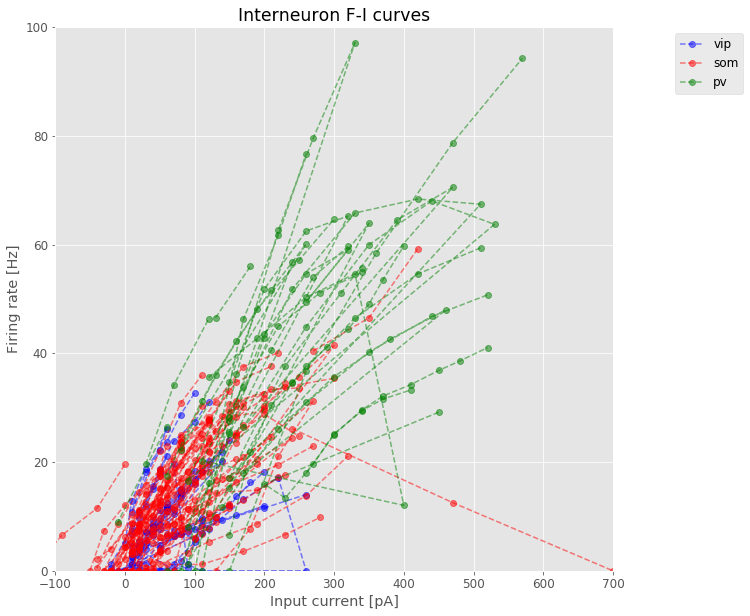

In [8]:
myaccord